In [2]:
import networkx as nx
import osmnx as ox

In [3]:
def _init_graph(G, growth_steps, built=True):
    if built:
        init_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
    # Find initial edges if not built by finding the ones that are not on the growth steps. Supposedly it's a single random edge from the highest closeness node, see growth.order_network_growth
    else:
        init_edges = [edge for edge in G.edges if edge not in growth_steps]
    return G.edge_subgraph(init_edges)

In [4]:
def get_subtractive_invalid_edges(G, built=True):
    """
    Find all invalid edges that if removed would create a new, unacceptable component to the graph. A new component is unacceptable if it's not a subgraph of a component that is part of the built graph but not of the actual graph.

    Args:
        G (networkx.Graph): Graph on which we want to remove edges.
        built (bool, optional): If True, there is a built component to the graph to take into account. This is represented by an edge attribute on all edges, that is 1 if it's built, 0 if it's not built. Defaults to True.

    Returns:
        list: List of tuple, each tuple being an invalid edge to remove from G.
    """
    # Find all bridges and remove bridges that when removed leave an isolated node
    invalid_edges = [
        edge
        for edge in nx.bridges(G)
        if not any(nx.degree(G, node) == 1 for node in edge[:2])
    ]
    # If there are elected nodes there are built edges that we can't remove
    if built:
        built_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
        invalid_edges += built_edges
        invalid_edges = set(invalid_edges)
        elected_nodes = elect_nodes(G.edge_subgraph(built_edges))
    # If built is False work stops before checking elected_nodes, if built is True elected_nodes is created so it works
    if built is False or nx.number_connected_components(G) == len(elected_nodes):
        return invalid_edges
    # New component can be created only if part of a new component with a built part
    else:
        updated_invalid_edges = invalid_edges.copy()
        for edge in invalid_edges:
            if edge not in built_edges:
                H = G.copy()
                H.remove_edge(*edge)
                # Accept edges (remove from invalid edges) that if removed from the graph create a new component with a built part
                if not any(
                    not any(node in cc for node in elected_nodes)
                    for cc in list(nx.connected_components(H))
                ):
                    updated_invalid_edges.remove(edge)
        return updated_invalid_edges


def get_additive_invalid_edges(G_actual, G_final):
    """
    Find all invalid edges that if added would create a new, unacceptable component to the graph. A new component is unacceptable if it's not a subgraph of a component that is part of the final graph but not of the actual graph.

    Args:
        G_actual (networkx.Graph): Graph on which we want to add edges.
        G_final (networkx.Graph): Final graph, from where we find potential edges that can be added to the actual graph.

    Returns:
        list: List of tuple, each tuple being an invalid edge to add to G_actual from G_final.
    """
    invalid_edges = [
        edge
        for edge in G_final.edges
        if (not any(node in G_actual for node in edge[:2])) or edge in G_actual.edges
    ]
    # If already the final number of cc or will connect in the future give list of adjacent edge only
    if nx.number_connected_components(G_actual) >= nx.number_connected_components(
        G_final
    ):
        return invalid_edges
    # Else a new component can be created, but need to be within a final component not already on the graph
    else:
        updated_invalid_edges = invalid_edges.copy()
        for edge in invalid_edges:
            new_edges = list(G_actual.edges)
            # Graph.edge_subgraph can only use list of tuple, not list of list
            new_edges.append(tuple(edge))
            H = G_final.edge_subgraph(new_edges)
            # Accept edges (remove from invalid edges) that if added to the graph create a new component that is a subgraph of a component of the final graph
            if not any(
                not any(node in cc for node in elect_nodes(H))
                for cc in list(nx.connected_components(G_final))
            ):
                updated_invalid_edges.remove(edge)
        return updated_invalid_edges


def elect_nodes(G):
    """Take one node from each components of G to represent them."""
    return [next(iter(cc)) for cc in list(nx.connected_components(G))]

In [5]:
G = ox.load_graphml(
    "../data/processed/plan_paris/paris_bikeplan_pruned_multigraph.graphml"
)
for e in G.edges:
    G.edges[e]["built"] = int(G.edges[e]["built"])

In [6]:
G_built = _init_graph(G, 0, built=True)

In [7]:
nx.number_connected_components(G_built)

19

In [ ]:
invalid = get_additive_invalid_edges(G_built, G)

In [17]:
for e in G.edges:
    if e in invalid:
        G.edges[e]["valid"] = 0
    else:
        G.edges[e]["valid"] = 1
    if G.edges[e]["built"] == 1:
        G.edges[e]["valid"] = 0.5

In [18]:
gdf = ox.graph_to_gdfs(G, edges=True, nodes=False)

<Axes: >

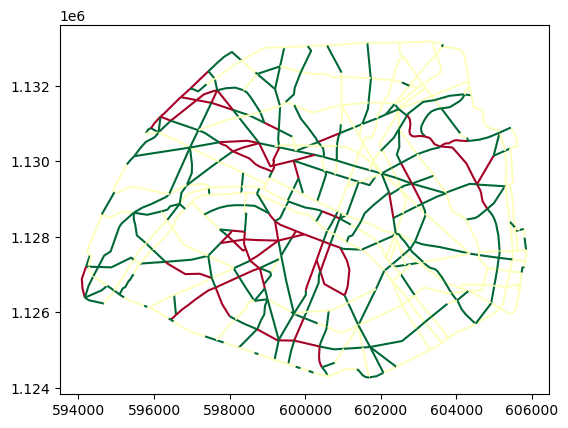

In [19]:
gdf.plot(column="valid", cmap="RdYlGn")

In [21]:
invalid = get_subtractive_invalid_edges(G, built=True)

In [22]:
for e in G.edges:
    if e in invalid:
        G.edges[e]["valid"] = 0
    else:
        G.edges[e]["valid"] = 1
    if G.edges[e]["built"] == 1:
        G.edges[e]["valid"] = 0.5

In [23]:
gdf = ox.graph_to_gdfs(G, edges=True, nodes=False)

<Axes: >

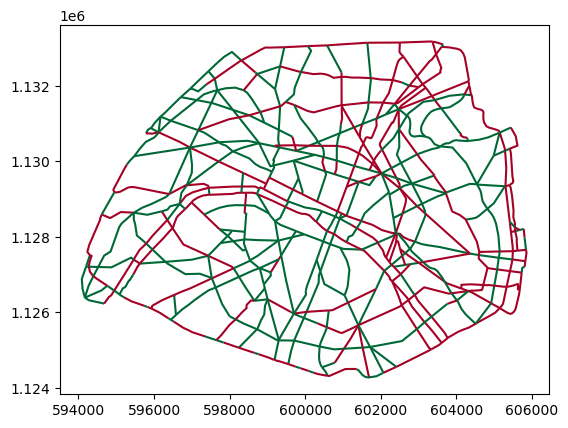

In [24]:
gdf.plot(column="valid", cmap="RdYlGn")